In [1]:
import glob
import os
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt

PARENT_DIR = "/Users/mbare/Documents/audana-dataset/dataset/Audio/"
SUB_DIRS = ["Truthful","Deceptive"]

In [7]:
def fex(file_name):
    X, sample_rate = librosa.load(file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    return mfccs


def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    # array with dimension = mfccs.shape + chroma.shape
    features, labels = np.empty((0,40)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, 
                                         sub_dir, 
                                         file_ext)):
            try:
                mfccs = fex(fn)
            except Exception as e:
              print ("Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, [1 if sub_dir=="Deceptive" else 0])
    return np.array(features), np.array(labels, dtype = np.int)

In [8]:
features, labels = parse_audio_files(PARENT_DIR, SUB_DIRS)

In [9]:
print(features.shape)
print(labels.shape)

(121, 40)
(121,)


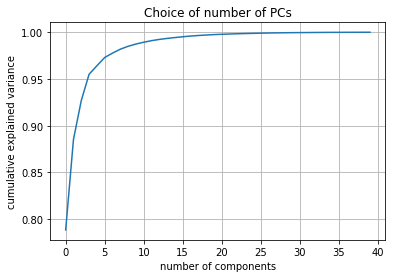

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Choice of number of PCs')
plt.grid(True)

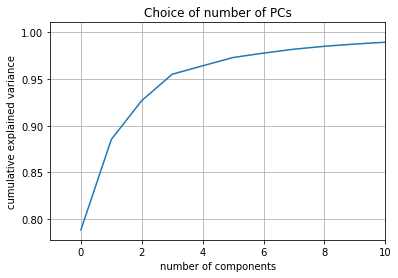

In [11]:
xmin = -1
xmax = 10
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Choice of number of PCs')
plt.xlim(xmin,xmax)
plt.grid(True)

In [12]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


standardized_features = StandardScaler().fit_transform(features)
reduced_pca = PCA(n_components=4)
principal_components = reduced_pca.fit_transform(standardized_features)
print(principal_components.shape)
print(labels.shape)

df_features = pd.DataFrame(data=features)
df_labels = pd.DataFrame(data=labels, columns=['label'])
df_features_and_labels = pd.concat([df_features, df_labels['label']], axis=1)
df_features_and_labels.tail()

(121, 4)
(121,)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
116,-358.355306,94.415814,-0.350819,10.142907,-3.679876,-20.022183,-16.579841,-12.708696,-12.933064,-3.735204,...,0.680033,-0.983068,1.773505,-0.114398,5.396056,3.408657,6.327762,2.661160,5.604755,1
117,-616.106252,158.321906,-18.357332,44.994190,4.076223,1.206783,17.703185,-14.488147,2.491090,-7.105201,...,1.694409,2.990318,1.170147,4.524802,-0.087311,3.028227,3.716431,-1.531751,3.808217,1
118,-339.486752,87.621269,-0.878842,6.663431,-6.175074,-16.212869,-15.636353,-9.505026,-14.643525,-4.014314,...,1.261211,-1.014982,3.534091,-0.228755,5.015391,1.469593,4.997812,0.276559,3.881045,1
119,-357.175207,95.897525,1.655496,3.293001,-4.225724,-16.720692,-17.230453,-11.820822,-13.484032,-3.005328,...,0.183520,-1.069986,2.464088,0.231598,4.867931,2.275063,4.857603,1.332177,4.265622,1
120,-213.228649,141.678837,31.045588,42.152237,20.988577,17.707597,7.422600,9.941549,-0.640248,2.111654,...,-2.604413,-3.075770,-2.958265,-4.016537,-3.572115,-3.538950,-2.491395,-3.499022,-3.302745,1


In [13]:
pc_df = pd.DataFrame(data=principal_components, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4'])
pc_df = pd.concat([pc_df, df_labels['label']], axis = 1)
pc_df.head(5)

,pc 1,pc 2,pc 3,pc 4,label
0,0.387282,0.258813,-2.773386,1.022096,0
1,0.101596,-3.659187,0.368888,-3.031923,0
2,-1.690836,-1.044317,3.474435,4.445592,0
3,-1.033900,-2.041137,0.364494,0.137173,0
4,-3.626598,-3.189643,-2.060299,1.769260,0


Truthful 0
Deceptive 1


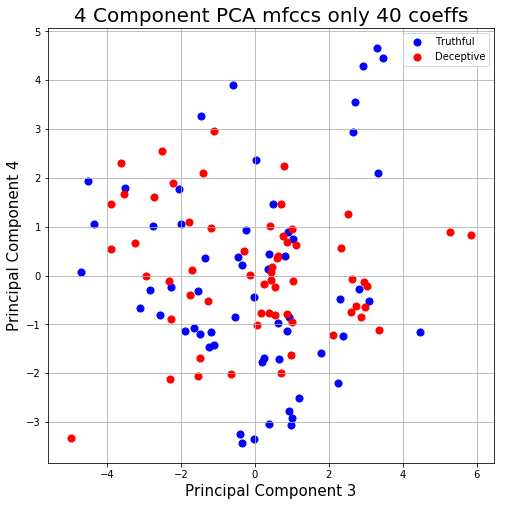

In [19]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 4', fontsize = 15)
ax.set_title('4 Component PCA mfccs only 40 coeffs', fontsize = 20)

hr_labels = SUB_DIRS
num_labels = [0,1]
for l,n in zip(hr_labels, num_labels):
    print(l,n)
colors = ['b', 'r']
for label, color in zip(num_labels,colors):
    indicesToKeep = pc_df['label'] == label
    ax.scatter(pc_df.loc[indicesToKeep, 'pc 3'],
               pc_df.loc[indicesToKeep, 'pc 4'],
               c = color,
               s = 50)
ax.legend(hr_labels)
ax.grid()